In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_4b62d946f8b3479485c8749068146791 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='9e0EhPuMmC4XyrNtqhN1gSir3lU97CZ7o7wcII_chywb',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_4b62d946f8b3479485c8749068146791.get_object(Bucket='tutorial-donotdelete-pr-xhapiymev5sr20',Key='insurance.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Feature Target Split

In [2]:
feature_dataset = df_data_1.iloc[:,0:-1]
target_dataset = df_data_1.iloc[:,-1]

### Feature Scaling

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
import numpy as np
#create the specs for the column transformer
#the function "make_column_transformer" will create the column transformer object
#categories="auto" and drop="first" tell the encoder to create k-1 columns, rather than k columns
# and that the first category will be the implicit category
preprocess = make_column_transformer(
    (StandardScaler(),['age', 'bmi']),
    (OneHotEncoder(categories="auto"),['bmi', 'children', 'smoker', 'region'])
)

#fit_transform is the function that fits the transformations to the data and then does the transformation
X = preprocess.fit_transform(feature_dataset)

# scale target dataset
sc_y = StandardScaler()
y = sc_y.fit_transform(np.array(target_dataset).reshape(-1,1))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Train Test Split

In [4]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

### Decision Tree Regression Model

In [5]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Test Data Evaluation

In [6]:
# prediction on testing dataset
prediction = model.predict(X_test)
test_result = pd.DataFrame(sc_y.inverse_transform(y_test))
test_result.columns = ['actual']
test_result['predicted'] = sc_y.inverse_transform(prediction)

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, model.predict(X_test)))
print ('Test Data have Root Mean Squared Error of {}'.format(rms))

Test Data have Root Mean Squared Error of 0.4715464165742322


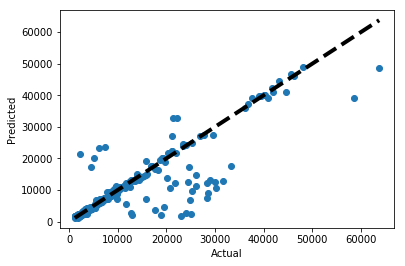

In [8]:
# Vizualiation (actual vs predicted) on testing dataset
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(test_result['actual'], test_result['predicted'])
ax.plot([test_result['actual'].min(), test_result['actual'].max()], [test_result['actual'].min(), test_result['actual'].max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()